## Sentiment Analysis for Whispr

1. import data from google sheets
2. evaluate sentiment of review, show confidence interval
3. output data to google sheet
4. plot sentiment counts

In [264]:
import pandas as pd
import numpy as np
import os
from textblob import TextBlob
import gspread
from datetime import datetime
from oauth2client.service_account import ServiceAccountCredentials
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

In [43]:
#1 define the scope of your access tokens
scope = ['https://www.googleapis.com/auth/drive','https://spreadsheets.google.com/feeds']

#2 after getting oauth2 credentials in a json, obtain an access token from google authorization server
#by creating serviceaccountcredentials and indicating scope, which controls resources / operations that an
#access token permits
creds = ServiceAccountCredentials.from_json_keyfile_name('client_secret.json', scope)

#3 log into the google API using oauth2 credentials
#returns gspread.Client instance
c = gspread.authorize(creds)

In [176]:
#create spreadsheet instance
spreadsheet = c.open('UK Sentiment')

#create worksheet instance
worksheet = spreadsheet.worksheet('UK_Reviews')

#get list of dictionaries from worksheet contents
records = worksheet.get_all_records()

#create dataframe from this list of dictionaries
reviews = pd.DataFrame(records)
columns_to_keep = ['review_rating',
                  'review_datedate',
                  'review_headline',
                  'review_size_info',
                  'Review']
clean_reviews = reviews[columns_to_keep]

In [271]:
#data preprocessing

#create numeric rating column
strip = lambda x: int(x[0])
clean_reviews['rating'] = clean_reviews['review_rating'].apply(strip)

#create timestamp from review date
dates = lambda x: datetime.strptime(x, '%d %B %Y')
clean_reviews['datestamp'] = clean_reviews['review_datedate'].apply(dates)

#create shortened object name
test = lambda x: x.split(': ')[-1]
clean_reviews['clean_headline'] = clean_reviews['review_size_info'].apply(test)

final_clean = clean_reviews[['rating','datestamp','clean_headline','review_headline','Review']]

/Users/christinejiang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/christinejiang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/christinejiang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

In [272]:
final_clean.head()

,rating,datestamp,clean_headline,review_headline,Review
0,5,2017-11-02,Dark Chocolate Nuts and Sea Salt,A very tasty and well-balanced treat,"I really like these bars, and so do the other ..."
1,5,2019-08-04,Dark Chocolate Nuts and Sea Salt,Great size snack for those of us wanting a hea...,I purchased these because I’m on the 16:8 IF d...
2,5,2019-08-20,Dark Chocolate Nuts and Sea Salt,Price varies a lot !!!,These are great bars. I find when I'm training...
3,5,2019-09-07,Dark Chocolate Almond Mint,Possibly the best tasting healthiest snack bar...,Not a protein bar but a very health-designed s...
4,5,2019-05-09,Dark Chocolate Nuts and Sea Salt,Definitely a bar to try and enjoy,So good and actually quite low in sugar all co...


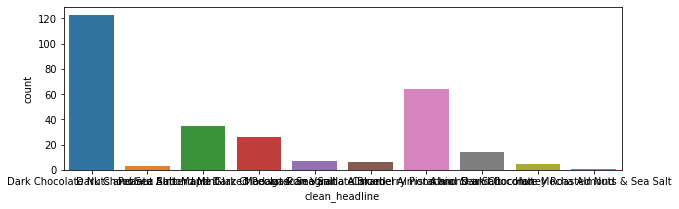

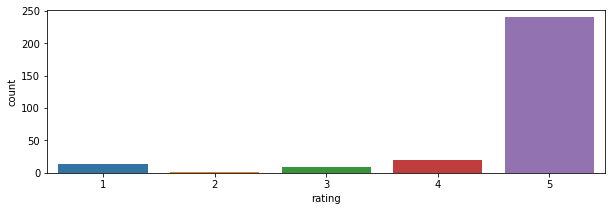

In [273]:
plt.rcParams['figure.figsize'] = [10,3]
plt.show(sns.countplot(final_clean['clean_headline']))

plt.show(sns.countplot(final_clean['rating']))

In [277]:
pol = lambda x: TextBlob(x).polarity
final_clean['headline_pol'] = final_clean['review_headline'].apply(pol)
final_clean['review_pol'] = final_clean['Review'].apply(pol)

/Users/christinejiang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/christinejiang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [280]:
final_clean[final_clean['review_pol'] < -0.5]

,rating,datestamp,clean_headline,review_headline,Review,headline_pol,review_pol
131,5,2018-05-18,Caramel Almond and Sea Salt,Five Stars,A bit expensive though...!?,0.0,-0.625
